In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-pack

In [2]:
#read data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print(train.shape)
print(test.shape)

(5000000, 3)
(2000000, 2)


In [4]:
train.head(5)

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [5]:
test.head(5)

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


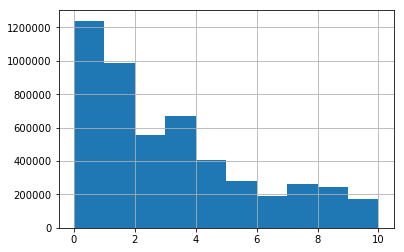

In [6]:
train['open_channels'].hist()

In [7]:
#RNN
import numpy as np
WINDOW_SIZE = 10
def generator_data(train, batch_size, WINDOW_SIZE = 100):
    X_train = []
    Y_train = []
    for i in range(WINDOW_SIZE,train.shape[0]):
        #print("DEBUG", i)
        feature = [[i]for i in train.to_numpy()[i-WINDOW_SIZE:i, 1]]
        X_train.append(feature)
        Y_train.append(int(train.to_numpy()[i,2]))
        if (i-WINDOW_SIZE+1) % batch_size == 0:
           # print(len(X_train))
            #print(len(Y_train))
            data_generate = (np.array(X_train), np.array(Y_train))
            X_train = [] 
            Y_train = []
            yield data_generate
#data_generator = generator_data(train, batch_size=8, WINDOW_SIZE=WINDOW_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.nn.rnn_cell import BasicRNNCell
tf.reset_default_graph()
sess=tf.Session()

WINDOW_SIZE = 100
signal = tf.placeholder(tf.float32, [None, WINDOW_SIZE, 1])
channel = tf.placeholder(tf.int32, [None])

rnn = BasicRNNCell(num_units=10)

output, state = tf.nn.dynamic_rnn(rnn, signal, dtype=tf.float32)
# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

print(last)
print(state)

weight = tf.Variable(tf.truncated_normal([10, 10], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[10]))
logits_out = tf.matmul(last, weight) + bias

# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=channel)
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(channel, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(0.005)
train_step = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)


train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
data_generator = generator_data(train, batch_size=64, WINDOW_SIZE=WINDOW_SIZE)
for epoch in range(int(5000000/64)):
    (x_train, y_train) = next(data_generator)
    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    sess.run(train_step, feed_dict={signal:x_train,channel:y_train})
    
    if epoch % 100:
        # Run loss and accuracy for training
        temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict={signal:x_train,channel:y_train})
        train_loss.append(temp_train_loss)
        train_accuracy.append(temp_train_acc)
        print("Loss :", temp_train_loss, "Acc :", temp_train_acc)


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Tensor("GatherV2:0", shape=(?, 10), dtype=float32)
Tensor("rnn/while/Exit_3:0", shape=(?, 10), dtype=float32)
Instructions for updating:
Use tf.cast instead.


C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loss : 2.1696382 Acc : 0.0
Loss : 2.1440134 Acc : 0.0
Loss : 2.1181548 Acc : 0.0
Loss : 2.0863383 Acc : 0.078125
Loss : 2.059177 Acc : 0.71875
Loss : 2.0323725 Acc : 1.0
Loss : 2.0019016 Acc : 1.0
Loss : 1.9711871 Acc : 1.0
Loss : 1.9420967 Acc : 1.0
Loss : 1.908423 Acc : 1.0
Loss : 1.878536 Acc : 1.0
Loss : 1.8478079 Acc : 1.0
Loss : 1.8156109 Acc : 1.0
Loss : 1.7777587 Acc : 1.0
Loss : 1.7537059 Acc : 1.0
Loss : 1.7140726 Acc : 1.0
Loss : 1.6737674 Acc : 1.0
Loss : 1.6419265 Acc : 1.0
Loss : 1.6090187 Acc : 1.0
Loss : 1.5614153 Acc : 1.0
Loss : 1.5345461 Acc : 1.0
Loss : 1.4970063 Acc : 1.0
Loss : 1.4454002 Acc : 1.0
Loss : 1.4114031 Acc : 1.0
Loss : 1.3804079 Acc : 1.0
Loss : 1.3282253 Acc : 1.0
Loss : 1.2849497 Acc : 1.0
Loss : 1.2497947 Acc : 1.0
Loss : 1.2069068 Acc : 1.0
Loss : 1.1623647 Acc : 1.0
Loss : 1.1238163 Acc : 1.0
Loss : 1.0750452 Acc : 1.0
Loss : 1.0334879 Acc : 1.0
Loss : 0.99047464 Acc : 1.0
Loss : 0.9473272 Acc : 1.0
Loss : 0.9059814 Acc : 1.0
Loss : 0.8754465 Acc 

In [ ]:
import numpy as np
WINDOW_SIZE = 10
def generator_data_test(test, batch_size, WINDOW_SIZE = 100):
    X_train = []
    for i in range(WINDOW_SIZE,train.shape[0]):
        #print("DEBUG", i)
        feature = [[i]for i in train.to_numpy()[i-WINDOW_SIZE:i, 1]]
        X_train.append(feature)
        if (i-WINDOW_SIZE+1) % batch_size == 0:
           # print(len(X_train))
            #print(len(Y_train))
            data_generate = (np.array(X_train))
            X_train = [] 
            yield data_generate
test_data_generator = generator_data_test(test, batch_size, WINDOW_SIZE = 100)
x_test = next(test_data_generator)  # x_test.shape(batchsize, 100)  
x_test_predict = sess.run(tf.nn.softmax(logits_out), feed_dict={signal:x_test})